Many members of our community focus on developing numerical models to study how landscapes evolve over time. The simplest and most commonly used transport law used to capture the evolution of hillslopes is a diffusion equation:

$$\frac{\partial z}{\partial t} = K \; \frac{\partial^2 z}{\partial x^2}$$

where $z$ is elevation, $x$ is the horizontal distance, and $K$ is a landscape diffusion coefficient.

## Finite difference methods

We can solve partial differential equations using finite difference methods by replacing the spatial and time derivatives with approximations that use the gridded data.

The time derivative $\partial z/\partial t$ can be approximated using a forward difference:

$$\frac{\partial z}{\partial t} \approx \frac{z_{x, \; t+1} - z_{x, \; t}}{\partial t}$$

The second spatial derivative $\frac{\partial^2 z}{\partial x^2}$ can be approximated by combining a forward and a backwards difference:

$$\frac{\partial^2 z}{\partial x^2} \approx \frac{z_{x+1, \; t} - 2 z_{x, \; t} + z_{x-1, \; t}}{(\partial x)^2}$$

The diffusion equation can then be rewritten as:

$$\frac{z_{x, \; t+1} - z_{x, \; t}}{\partial t} = K \;  \frac{z_{x+1, \; t} - 2 z_{x, \; t} + z_{x-1, \; t}}{(\partial x)^2}$$

We can rearrange this equation to solve for the elevation $z$ at position $x$ at timestep $t+1$:

$$z_{x, \; t+1} = z_{x, \; t} + K \; \partial t \; \frac{z_{x+1, \; t} - 2 z_{x, \; t} + z_{x-1, \; t}}{(\partial x)^2}$$



## Diffusion in 1D

We can start by simulating the evolution of the topography (from our dataset) in 1D. Let's first extract a profile across the DEM:

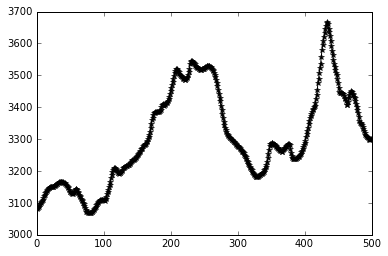

In [11]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

topo = np.loadtxt('data/topo.asc', delimiter=',')

profile = topo[:,120]

plt.plot(profile, 'k*-')

To simulate the evolving topography, we will follow this algorithm:

* loop through time ($\; \partial t \;$)
    * step through the profile ($\; \partial x \;$)
        * calculate $z_{x, \; t+1}$
        
At every timestep, we will use the elevations at time $t$ to calculate the elevations at time $t+1$. We need to create a new array of the same size as the old profile to store the values of the new profile. We will also create a new variable to keep track of the old profile. Because NumPy arrays are mutable objects, we need to make a copy of the profile object.

In [14]:
newProfile = np.zeros_like(profile)

oldProfile = profile.copy()